<a href="https://colab.research.google.com/github/bentondecusin/HJM/blob/main/hjm_3f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from mpl_toolkits.mplot3d import Axes3D
import copy as copylib
from progressbar import *
%pylab
%matplotlib inline
import pandas as pd
import numpy as np
np.random.seed(69420)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
plt.style.use('tableau-colorblind10')

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['__version__']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Setup
We will use the US treasury par yields as a proxy of forward rate.

In [2]:
url2 = 'https://raw.githubusercontent.com/omartinsky/HJM/refs/heads/main/hjm_data.csv'
url = "https://raw.githubusercontent.com/bentondecusin/HJM/refs/heads/main/govie.csv"
def dfByYear(yr):
    return pd.read_csv(f"https://home.treasury.gov/resource-center/data-chart-center/interest-rates/daily-treasury-rates.csv/{yr}/all?type=daily_treasury_yield_curve&field_tdr_date_value={yr}&page&_format=csv")


In [3]:
# # Real data
# df2024 = dfByYear(2024)
# df2023 = dfByYear(2023)
# df2022 = dfByYear(2022)
# df = pd.concat([df2024, df2023, df2022], axis=0)
# df = df.set_index('Date')
# df.index = pd.to_datetime(df.index, format='%m/%d/%Y', errors='coerce')


In [43]:
par_yields = pd.read_csv(url)
par_yields = par_yields.dropna(axis=1, how='any') # Drop any Treasury that has NaN values
par_yields = par_yields.set_index('Date') # Index by Date
par_yields = par_yields.sort_index(ascending=True) # Index by Date
# The x-axis would be tenors:     noted as big Delta
# The y-axis would be past dates: noted as small t
# i.e. par_yields[t][D] is a spot rate r(t,t,D)
tenors_str = par_yields.columns
tenors_float = [1/12, 2/12, 3/12, 6/12, 1,2,3,5,7,10,20,30]
dates = list(par_yields.index)
display(par_yields.iloc[:5,:])

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,,,
2022-01-03,0.05,0.06,0.08,0.22,0.40,0.78,1.04,1.37,1.55,1.63,2.05,2.01
2022-01-04,0.06,0.05,0.08,0.22,0.38,0.77,1.02,1.37,1.57,1.66,2.10,2.07
2022-01-05,0.05,0.06,0.09,0.22,0.41,0.83,1.10,1.43,1.62,1.71,2.12,2.09
2022-01-06,0.04,0.05,0.10,0.23,0.45,0.88,1.15,1.47,1.66,1.73,2.12,2.09
2022-01-07,0.05,0.05,0.10,0.24,0.43,0.87,1.17,1.50,1.69,1.76,2.15,2.11


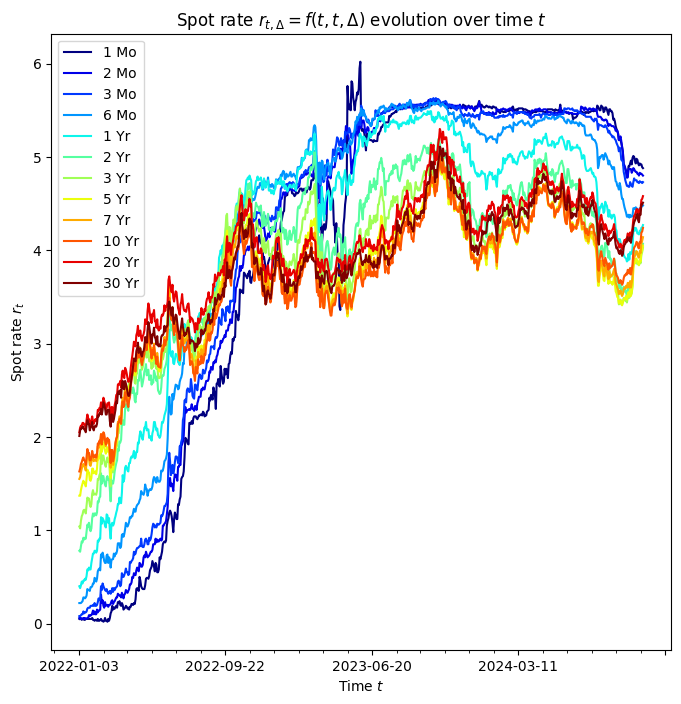

In [44]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel(f'Time $t$')
ax.set_ylabel(f'Spot rate $r_t$')
colors = plt.cm.jet(np.linspace(0,1,len(tenors_str)))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
for i, tenor in enumerate(tenors_str):
    ax.plot(par_yields.index, par_yields[tenor], label=tenor, color=colors[i])
ax.legend(loc='best')
plt.title('Spot rate $r_{t, \Delta} = f(t,t,\Delta )$ evolution over time $t$')
plt.show();

We first plot each tenor's par yield against the time t. Many insights, such as rate hikes since 2022, yield inversion in 2022Q3, rate cut in 2024Q3.

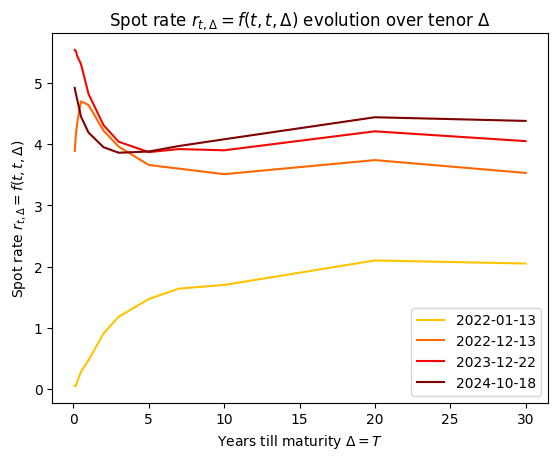

In [67]:
plt.xlabel(f'Years till maturity $\Delta = T$')
plt.ylabel('Spot rate $r_{t, \Delta} = f(t,t,\Delta )$ ')
selected_dates = ['2022-01-13', '2022-12-13', '2023-12-22', '2024-10-18']
colors = plt.cm.jet(np.linspace(0.7,1,len(selected_dates)))
for i, date_ in enumerate(selected_dates):
    plt.plot(tenors_float, par_yields.loc[date_], label=date_, color=colors[i])
plt.legend(loc='best')
plt.title('Spot rate $r_{t, \Delta} = f(t,t,\Delta )$ evolution over tenor $\Delta$')
plt.show();

Then we plot the classical yield against for selected dates. Since December 2022, the Fed had been raising effective federal funds rate (EFFR). The last rate hike was March 22, 2023. As of the time I wrote this blog, the last rate cut was July 31, 2024. We can see that over tthe time the entire curve shifts up. Yield curve inversion can be observed in late 2022. And after the rate cut on July 31, 2024, the rate steepens. Hmm, perhaps J Pow made the soft landing :))

Enough econ yapping, back to business. We want to analyze the volatilities so we can cook the term strucure using HJM. We calculate the overnight (close to instant) change of spot rate, defined as $dr_t = r_t - r_{t-1} \Leftrightarrow df(t,t) = df(t,t) - df(t-1,t-1)$, to represent the yield volatility
Ok, what's next, we want to find a way to express this volatility using linear terms

Latest 5  dr(t)


,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,,,
2022-01-03,0.01,-0.01,0.00,0.00,-0.02,-0.01,-0.02,0.00,0.02,0.03,0.05,0.06
2022-01-04,-0.01,0.01,0.01,0.00,0.03,0.06,0.08,0.06,0.05,0.05,0.02,0.02
2022-01-05,-0.01,-0.01,0.01,0.01,0.04,0.05,0.05,0.04,0.04,0.02,0.00,0.00
2022-01-06,0.01,0.00,0.00,0.01,-0.02,-0.01,0.02,0.03,0.03,0.03,0.03,0.02
2022-01-07,0.00,0.01,0.03,0.04,0.03,0.05,0.04,0.03,0.02,0.02,0.00,0.00


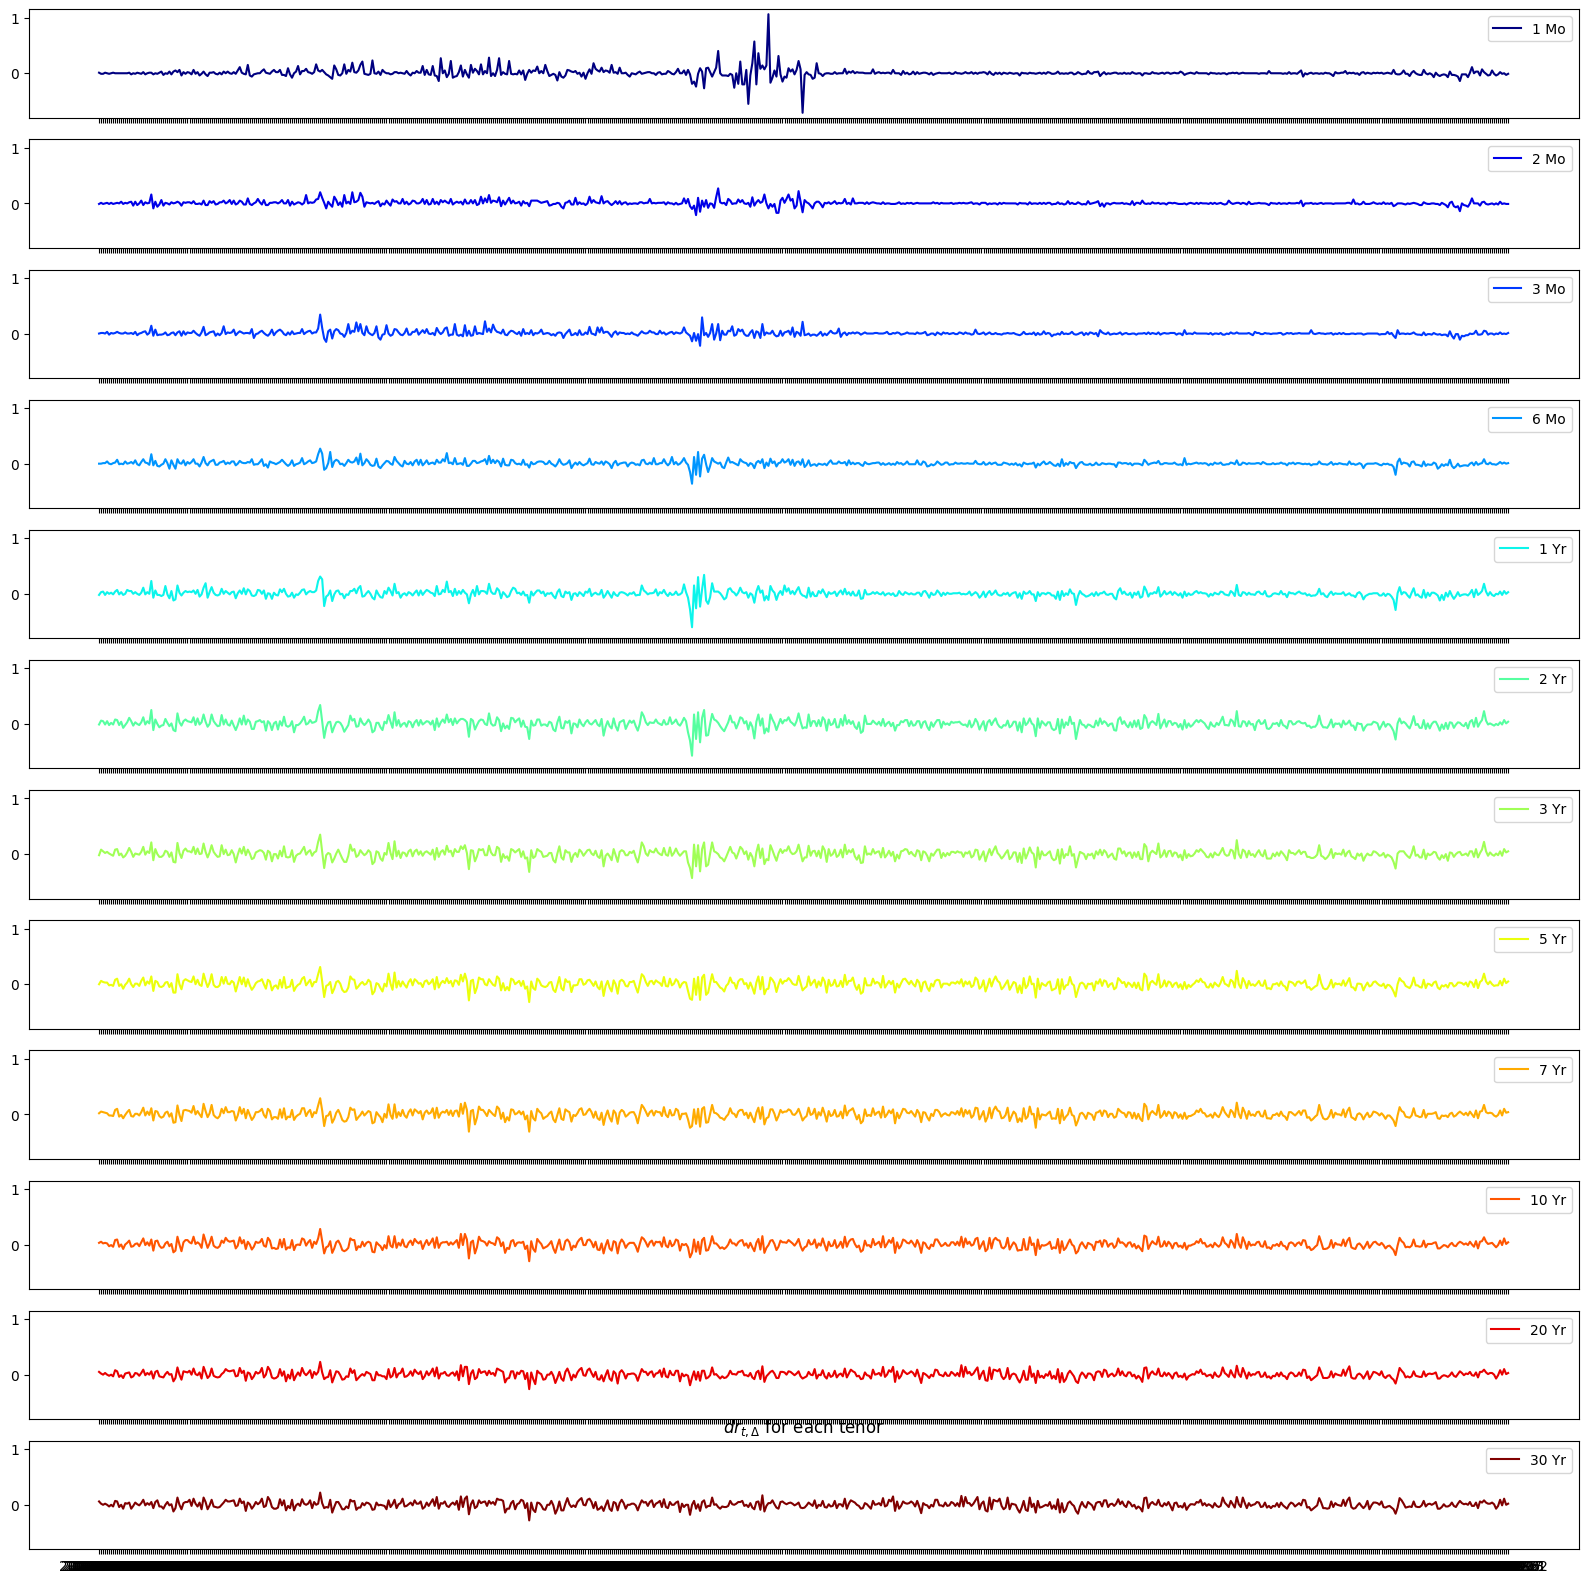

In [69]:
dftt = pd.DataFrame(np.diff(par_yields, axis=0),
                    index=par_yields.index[:-1],
                    columns=par_yields.columns)
# Remove the first date, n rows -> n-1 rows
# dftt[i,j] = ftt[i,j] - ftt[i-1][j]
print("Latest 5  dr(t)")
display(dftt.iloc[:5]) # TOP 5 dftt
colors = plt.cm.jet(np.linspace(0,1,len(tenors_str)))

fig, ax = plt.subplots(len(tenors_str), sharex=True, sharey=True, figsize=(20,20))
for i, tenor in enumerate(tenors_str):
    ax[i].plot(dftt.index, dftt[tenor], label=tenor, color=colors[i])
    ax[i].legend(loc='best')
plt.title('$dr_{t, \Delta}$ for each tenor')

plt.show()


Eigen vector


,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
pca0,0.019442,0.063791,0.092014,0.160171,0.279462,0.386973,0.405549,0.399296,0.382303,0.343137,0.280191,0.259369
pca1,0.969345,0.222553,0.069763,0.034881,0.027439,-0.004218,-0.013755,-0.027377,-0.030168,-0.022803,-0.025544,-0.031074
pca2,-0.118822,0.181271,0.266207,0.336211,0.437822,0.324321,0.158840,-0.038974,-0.177739,-0.279199,-0.391666,-0.427260
pca3,-0.136440,0.370820,0.661731,0.319184,-0.040354,-0.280816,-0.256259,-0.138616,-0.042159,0.071696,0.236570,0.275423
pca4,-0.159747,0.843130,-0.180099,-0.355525,-0.239009,0.077111,0.106462,0.110277,0.044407,0.009934,-0.077211,-0.100892
pca5,0.039868,-0.245441,0.578593,-0.222136,-0.565574,0.086148,0.253865,0.221610,0.123637,0.001509,-0.184936,-0.252411
pca6,-0.003220,0.066381,-0.327739,0.747717,-0.442846,-0.190256,0.091139,0.165025,0.147923,0.040361,-0.088539,-0.172891
pca7,0.006893,-0.010052,-0.056122,0.149122,-0.390218,0.680990,-0.003788,-0.273267,-0.343335,-0.192529,0.221196,0.282639
pca8,-0.002736,0.010982,-0.009501,-0.012871,0.023514,-0.377787,0.800709,-0.223463,-0.266429,-0.206267,0.087926,0.209780
pca9,0.007984,-0.010729,-0.004093,-0.011182,0.035436,-0.097329,-0.132141,0.741906,-0.303519,-0.528095,0.177632,0.136029


Eigen values


,0
pca0,3.151850
pca1,1.331100
pca2,1.121832
pca3,0.763831
pca4,0.507901
pca5,0.434294
pca6,0.294190
pca7,0.256947
pca8,0.179080
pca9,0.121682


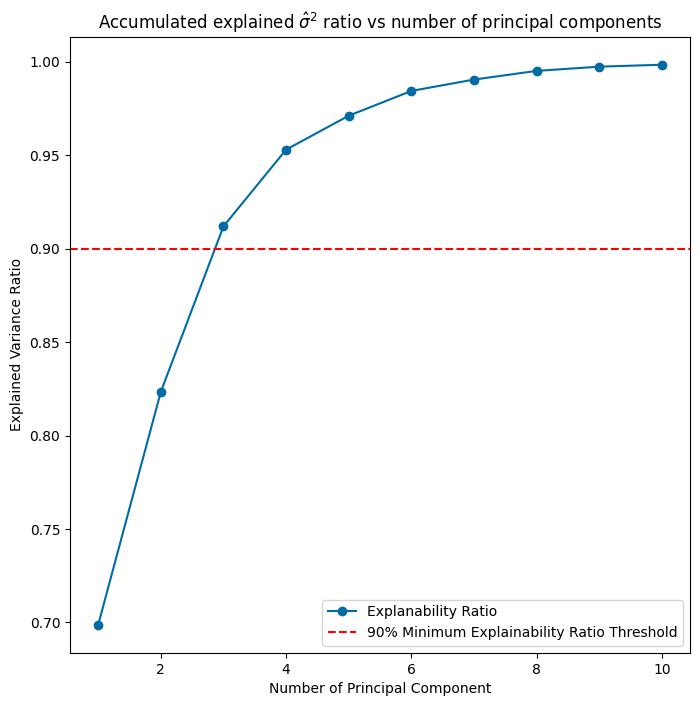

In [8]:
n_components = 10
pca = PCA(n_components=n_components, svd_solver='full') # Get at least 10 explanable tenors
pca.fit(dftt * np.sqrt(252)) # Anualize df(t,t)

print('Eigen vector')
display(pd.DataFrame(pca.components_, index=pca.get_feature_names_out(), columns=tenors_str ))
print('Eigen values')
display(pd.DataFrame(np.sqrt(pca.explained_variance_), index=pca.get_feature_names_out() ))

acc_explained_var_ratio = pca.explained_variance_ratio_.cumsum()
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(np.arange(1, n_components+1), acc_explained_var_ratio, marker='o', label='Explanability Ratio')
ax.set_xlabel('Number of Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.axhline(0.9, color='red', label='90% Minimum Explainability Ratio Threshold', ls='--')
ax.legend(loc='best')
plt.title('Accumulated explained $\hat{\sigma}^2$ ratio vs number of principal components')
plt.show()


For simple illustration, we will use the first 3 principal components as they could explain 90% of the volatilities.
# Loadings
But before we examine the first two component, let's quickly revisit **loadings**     
$\text{Loadings} = \text{eigen vector }\cdot \sqrt{\text{eigen values }}$  
What we did in PCA was decompoing covariance matrix into a scalar part (eigen value) and a vector part (eigen vector). As a weighed version of eigen vector, loadings are regression factors (not necessarily correlations), and inidcate how strongly the *volatiliy of a tenor* and a *principal component* are associated

,pca0,pca1,pca2
1 Mo,0.019442,0.969345,-0.118822
2 Mo,0.063791,0.222553,0.181271
3 Mo,0.092014,0.069763,0.266207
6 Mo,0.160171,0.034881,0.336211
1 Yr,0.279462,0.027439,0.437822
2 Yr,0.386973,-0.004218,0.324321
3 Yr,0.405549,-0.013755,0.158840
5 Yr,0.399296,-0.027377,-0.038974
7 Yr,0.382303,-0.030168,-0.177739
10 Yr,0.343137,-0.022803,-0.279199


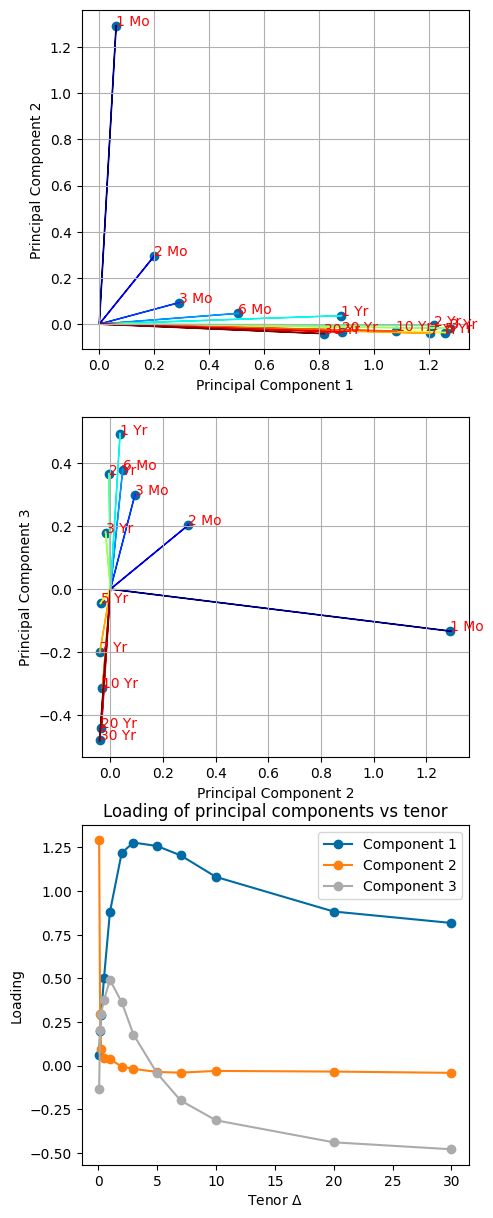

In [35]:
pca = PCA(n_components=3, svd_solver='full') # Get at least 10 explanable tenors
pca.fit(dftt * np.sqrt(252)) # Anualize df(t,t)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
display(pd.DataFrame(pca.components_.T, index=tenors_str, columns=pca.get_feature_names_out()))

fig, ax = plt.subplots(3, 1, figsize=(5,15))
for j in range(2):
  pcX, pcY = j, j+1
  ax[j].scatter(loadings[:, pcX], loadings[:, pcY])
  ax[j].set_xlabel(f'Principal Component {pcX+1}')
  ax[j].set_ylabel(f'Principal Component {pcY+1}')
  # Add variable labels to the plot
  colors = plt.cm.jet(np.linspace(0,1,len(tenors_str)))
  for i, tenor in enumerate(tenors_str):
      ax[j].annotate(tenor, xy=(loadings[i, pcX], loadings[i, pcY]), color='red')
      ax[j].arrow(x=0, y=0, dx=loadings[i, pcX], dy=loadings[i, pcY], color=colors[i])
  ax[j].grid(True)
ax[2].plot(tenors_float, loadings, marker='o', label=[f'Component {i+1}' for i in range(3)])
ax[2].legend(loc='best')
ax[2].set_xlabel('Tenor $\Delta$')
ax[2].set_ylabel('Loading')
ax[2].set_title('Loading of principal components vs tenor')

plt.show()

Note that principal components are now new magical features/variable/factors composed of volatities of differently-tenored Treasuries.  
Quick review on Treasuries naming:
- T-bills is the short-term (tenor <= 1 yr) Treasuries
- T-notes is the mid-term (1 < tenor < 10 yr) Treasuries
- T-bonds is the long-term (10yr < tenor ) Treasuries


Based on the loading plots, we have some interesting insights:
1.   The 1st principal component primarily explains the volatility of T-note (mid-term) and T-bond (long-term) par yield
2.   The 2nd principal component primarily explains the volatility of the 1-month T-bill (short-term) par yield
3.   The 3rd principal component explains the negative association between volatility of T-bill (short-term) and that of T-bond (long-term)

This aligns with the reality that, short-term yields are more directly affected by monetary policies than long-term yield. Although short-term and long-term yields usually move in the same direction, but the latter move in a smaller magnitude. This is because long-term yields reflect the martket's expecation of economic performances.
When the yield curve flatten or steepens, two ends of the curve could move in different direction, or same direction but in a significantly different magnitudes.

In other words, the 1st principal component explains the effect of monetary policy on left-hand side of term rate evolution. The 2nd principal component explains the economic performance on right-hand side of term rate evolution. The 3rd principal component, along with the 1st and 2nd, explains the behavior of steepening and flattening

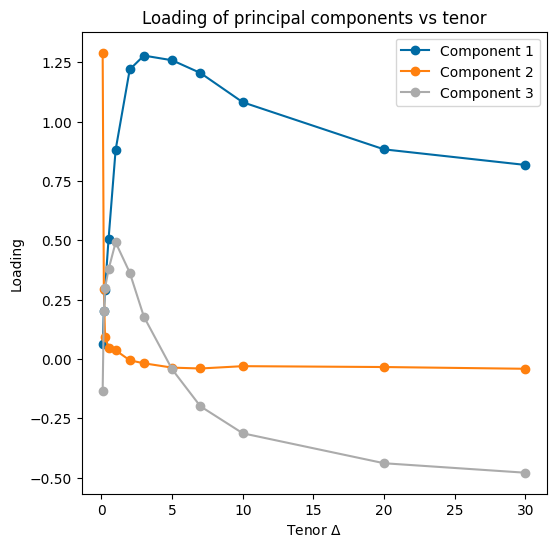

As we plot the loadings agaisnt each tenor, we can see that the

In [79]:
class Simulator:
  def __init__(self):
    pass
